## INSY 669 - Text Analytics

### Winter 2024

### Dr. Taha Havakhor

### Group Assignment

Submitted by:
- Chien Chen Liew (261178093)
- Farah Hoque (261149217)
- Hao Hao Duong (261104689)
- Jared Balakrishnan (261175926)
- Seunghyun Park (260686853


In [1]:
# importing all the modules required to run this notebook

from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import MDS
import re 
import spacy
import spacy.cli
from spacy.lang.en import English
from spacy.lang.en import stop_words
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

## Reading in the Datasets

### Edmunds Scraping Output (stored in the dataframe *edmunds*)
### Brand-Model dataframe (stores in the dataframe *models*)

In [2]:
# setting up the dataset file path
dataset_path: Path = Path().absolute()

def read_dataset(file_path: Path) -> pd.DataFrame :
    """File to read in the Edmunds dataset that was scraped by the edmunds-scraper.py script"""
    return pd.read_csv(file_path, header = 0, names = ["username", "month_year", "post"])

In [3]:
edmunds = read_dataset(dataset_path / "edmunds_extraction-2.csv")

In [4]:
print(f"Number of user-generated posts in the dataset: {edmunds.shape[0]}")

Number of user-generated posts in the dataset: 19749


In [6]:
# Reading in the brand-model mapping data
models: pd.DataFrame = pd.read_csv("models.csv", header = 0, names = ["brand", "model"])

# some pre-processing removing any leading or trailing punctuations from the brand name and model columns
models['brand'] = models['brand'].apply(lambda x: x.strip(punctuation))
models['model'] = models['model'].apply(lambda x: x.strip(punctuation))

## Creating a Model-Brand Map 

### Required since we will be replacing models with brands later

In [7]:
# Creating a map of the model to the brand
model_brand_dict: dict[str, str] = models.set_index('model')['brand'].to_dict()

## Task A: Performing a frequency count to obtain the 10 most frequently mentioned brands

In [8]:
# Getting the top 10 brands out of the existing dataset 

# getting all of the unique brand names into a list
distinct_brands: list[str] = list(set(models['brand'].unique()) - set({'sedan', 'car', 'seat', 'problem'}))

edmunds['post'] = edmunds['post'].apply(lambda x: x.lower())

# store brand mentions in a new pandas data frame
edmunds_brands: pd.DataFrame = pd.DataFrame(index = distinct_brands, columns = ['mentions'])

edmunds_brands['mentions'] = 0

for brand in distinct_brands:

    edmunds_brands.at[brand, 'mentions'] = edmunds['post'].str.contains(brand, na = False).sum()

top_10_brands: pd.DataFrame = edmunds_brands.sort_values(by = 'mentions', ascending = False)
top_10_brands.reset_index(inplace = True)
top_10_brands.drop_duplicates(subset = ['index', 'mentions'], inplace = True)
top_10_brands = top_10_brands.head(10)

In [9]:
# Preview of the top 10 brands
top_10_brands

,index,mentions
0,honda,2725
1,mazda,2649
2,ford,2624
3,toyota,1815
4,hyundai,1420
5,nissan,761
6,kia,636
7,chrysler,457
8,bmw,423
9,audi,384


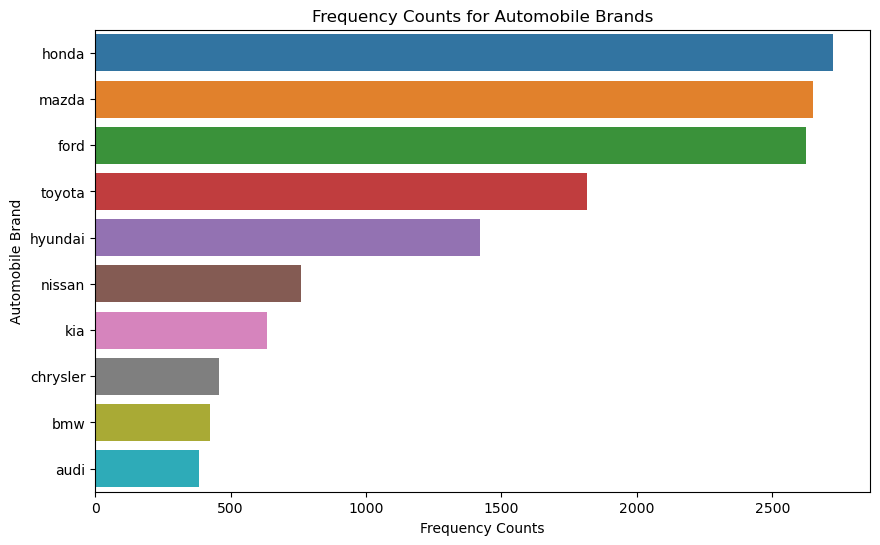

In [10]:
# Plotting the frequency counts of the top 10 brands

plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.barplot(x='mentions', y='index', data = top_10_brands, orient='h')

# Add labels and title
plt.xlabel('Frequency Counts')
plt.ylabel('Automobile Brand')
plt.title('Frequency Counts for Automobile Brands')

# Save the figure to a file
plt.savefig('top_10_brands.png', bbox_inches='tight')

plt.show()

## Replacing Models with Brands

In [11]:
# Replacing models with brands

# deleting these keys since they add zero value 
del model_brand_dict['cars']
del model_brand_dict['seats']
del model_brand_dict['sedans']
del model_brand_dict['problems']

# converting everything to lowercase to have uniformity across all dataframes
model_brand_dict: dict = {key.lower(): value.lower() for key, value in model_brand_dict.items()}

In [12]:
def replace_models_with_brands(post: str) -> str:

    """Function that replaces the occurrence of a model with its corresponding brand"""

    words = post.split()

    for index, word in enumerate(words):

        if word in model_brand_dict:

            words[index] = model_brand_dict[word]
    
    return ' '.join(words)

In [13]:
# Replacing the models in the actual Edmunds data with the associated brand
edmunds['post'] = edmunds['post'].apply(replace_models_with_brands)

## Setting up a text pre-processor

### Pre-Processing Steps Followed:
- Conversion to lowercase
- Removal of new line characters
- Removal of any links
- Expand any contractions in a given post to have its full form (with the dictionary initialized in the beginning)
- Tokenization, Lemmatization and put back the lemmatized form of the string together
- Remove any multiple whitespaces
- Remove leading / trailing whitespaces

In [14]:
# Setting up a dictionaries of possible contractions in the english language and then converting them to lower case via dict comprehension

contraction_dict: dict[str, str] = {
    "aren't": "are not",
    "can't": "cannot",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he's": "he is",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it's": "it is",
    "let's": "let us",
    "mustn't": "must not",
    "shan't": "shall not",
    "she's": "she is",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "they're": "they are",
    "we're": "we are",
    "weren't": "were not",
    "won't": "will not",
    "wouldn't": "would not",
    "you're": "you are",
}

contraction_dict = {key.lower(): value.lower() for key, value in contraction_dict.items()}

In [15]:
def text_preprocessing(x):

    lemmatizer = WordNetLemmatizer()

    # convert everything to lowercase
    x = x.lower()
    # remove new line
    x = re.sub(r'\n', ' ', x)
    # remove any links
    x = re.sub(r"https?://[^\s]+", "", x)
    # expand any/all contractions
    for contraction, expansion in contraction_dict.items():
        x = x.replace(contraction, expansion)
    # tokenization
    tokens = word_tokenize(x)
    # lemmatize and join back
    x = ' '.join([lemmatizer.lemmatize(word) for word in tokens])
    # remove multiple space
    x = re.sub(r' +', ' ', x)
    # remove space before and after the text
    x = x.strip()

    return x

In [16]:
#  Creating a more memory efficient iterable than a Pandas series to hold all of the user-generated Edmunds posts
all_posts: list[str] = edmunds['post'].tolist()

In [17]:
# Initializing a vectorizer
vectorizer = CountVectorizer(stop_words=list(stop_words.STOP_WORDS),
                             preprocessor = text_preprocessing)

In [18]:
dtm = vectorizer.fit_transform(all_posts)

/Users/chien/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'le', 'll', 've', 'wa'] not in stop_words.
  warnings.warn(


In [19]:
dtm

<19749x28631 sparse matrix of type '<class 'numpy.int64'>'
	with 702035 stored elements in Compressed Sparse Row format>

In [20]:
feature_names = vectorizer.get_feature_names_out()

In [21]:
dtm_array = dtm.toarray()

## Task A: Computing Lift between the top 10 Brands

In [22]:
indices: list = [np.where(feature_names == brand)[0][0] for brand in top_10_brands['index'].tolist() if brand in feature_names]

In [23]:
filtered_dtm_array = dtm_array[:, indices]

In [24]:
term_lift = np.dot(filtered_dtm_array.T, filtered_dtm_array)
term_occurrence = np.sum(filtered_dtm_array, axis = 0)

In [25]:
lift_matrix = term_lift / (np.outer(term_occurrence, term_occurrence) + 1e-8)

In [26]:
for i, brand1 in enumerate(top_10_brands['index'].tolist()):
    for j, brand2 in enumerate(top_10_brands['index'].tolist()):
        if i < j:
            print(f"Lift between {brand1} and {brand2}: {lift_matrix[i, j]:.4f}")

Lift between honda and mazda: 0.0001
Lift between honda and ford: 0.0001
Lift between honda and toyota: 0.0001
Lift between honda and hyundai: 0.0001
Lift between honda and nissan: 0.0001
Lift between honda and kia: 0.0001
Lift between honda and chrysler: 0.0001
Lift between honda and bmw: 0.0001
Lift between honda and audi: 0.0001
Lift between mazda and ford: 0.0001
Lift between mazda and toyota: 0.0000
Lift between mazda and hyundai: 0.0000
Lift between mazda and nissan: 0.0001
Lift between mazda and kia: 0.0001
Lift between mazda and chrysler: 0.0001
Lift between mazda and bmw: 0.0001
Lift between mazda and audi: 0.0001
Lift between ford and toyota: 0.0001
Lift between ford and hyundai: 0.0001
Lift between ford and nissan: 0.0001
Lift between ford and kia: 0.0001
Lift between ford and chrysler: 0.0001
Lift between ford and bmw: 0.0000
Lift between ford and audi: 0.0001
Lift between toyota and hyundai: 0.0001
Lift between toyota and nissan: 0.0001
Lift between toyota and kia: 0.0001


In [32]:
# to create lift table

brands = top_10_brands['index'].tolist()

# Create an empty DataFrame
lift_df = pd.DataFrame(index=brands, columns=brands)

# Fill the DataFrame with lift values
for i, brand1 in enumerate(brands):
    for j, brand2 in enumerate(brands):
        if i < j:
            lift_value = lift_matrix[i, j]
            # Since lift is symmetric, fill both [brand1, brand2] and [brand2, brand1]
            lift_df.at[brand1, brand2] = lift_value
            lift_df.at[brand2, brand1] = lift_value

# Filling diagonal values with 0 (lift of brand with itself)
np.fill_diagonal(lift_df.values, 0)

# Round the DataFrame to 4 decimal places
lift_df = lift_df.applymap(lambda x: round(x, 4))

# Display the DataFrame
lift_df

,honda,mazda,ford,toyota,hyundai,nissan,kia,chrysler,bmw,audi
honda,0.0000,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001
mazda,0.0001,0.0000,0.0001,0.0000,0.0000,0.0001,0.0001,0.0001,0.0001,0.0001
ford,0.0001,0.0001,0.0000,0.0001,0.0001,0.0001,0.0001,0.0001,0.0000,0.0001
toyota,0.0001,0.0000,0.0001,0.0000,0.0001,0.0001,0.0001,0.0001,0.0001,0.0000
hyundai,0.0001,0.0000,0.0001,0.0001,0.0000,0.0001,0.0002,0.0001,0.0001,0.0001
nissan,0.0001,0.0001,0.0001,0.0001,0.0001,0.0000,0.0001,0.0001,0.0001,0.0001
kia,0.0001,0.0001,0.0001,0.0001,0.0002,0.0001,0.0000,0.0001,0.0000,0.0002
chrysler,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0000,0.0001,0.0001
bmw,0.0001,0.0001,0.0000,0.0001,0.0001,0.0001,0.0000,0.0001,0.0000,0.0006
audi,0.0001,0.0001,0.0001,0.0000,0.0001,0.0001,0.0002,0.0001,0.0006,0.0000


In [33]:
dissimilarity_matrix = 1 / lift_matrix

## Task A: Developing an MDS Plot

/Users/chien/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


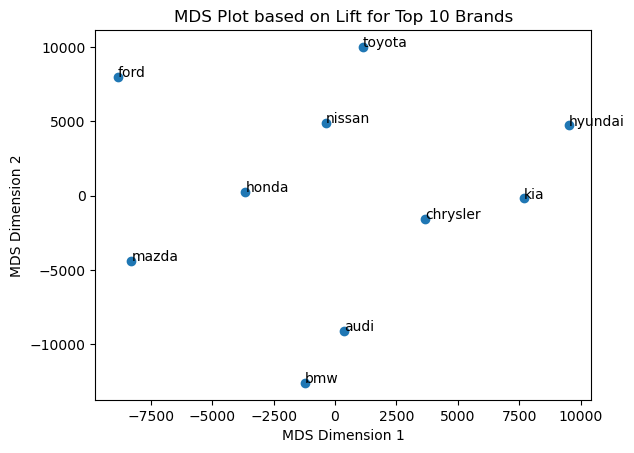

In [34]:
# Apply MDS to reduce dimensionality to 2D
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_result = mds.fit_transform(dissimilarity_matrix)

# Plot the MDS result
plt.scatter(mds_result[:, 0], mds_result[:, 1])

# Annotate points with brand names
for i, brand in enumerate(top_10_brands['index'].tolist()):
    if brand in feature_names:
        plt.annotate(brand, (mds_result[i, 0], mds_result[i, 1]))

plt.title('MDS Plot based on Lift for Top 10 Brands')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.savefig('MDS Plot.png', bbox_inches='tight')
plt.show()

## Task C

In [35]:
#   definining a dictionary to store some car-related attributes and possible terms

car_attributes: dict[str, list[str]] = {
    "performance": ["pick-up", "acceleration", "speed", "handling", "power", "horsepower", "torque", "dynamics"],
    "comfort": ["seats", "legroom", "ride", "interior", "spaciousness", "ergonomics", "cabin comfort", "seat comfort"],
    "reliability": ["dependable", "durable", "long-lasting", "maintenance", "build quality", "longevity"],
    "safety": ["airbags", "crash test", "safety features", "brakes", "collision avoidance", "lane assist", "blind spot"],
    "efficiency": ["mileage", "fuel economy", "mpg", "fuel efficiency", "energy consumption", "emissions"],
    "design": ["styling", "aesthetics", "look", "appearance", "body", "exterior"],
    "technology": ["infotainment", "connectivity", "navigation", "bluetooth", "smart features", "voice control"],
    "luxury": ["leather", "premium", "high-end", "exclusive", "refinement", "sophistication"],
    "value": ["price", "cost-effective", "affordable", "economical", "worth", "budget-friendly", "cheap", "budget"],
    "environmental impact": ["eco-friendly", "green", "sustainable", "low emissions", "electric", "hybrid"]
}

In [36]:
attribute_counts = {attribute: 0 for attribute in car_attributes}

for message in all_posts:
    message_str = message.lower()
    for attribute, synonyms in car_attributes.items():
        if any(synonym in message_str for synonym in synonyms):
            attribute_counts[attribute] += 1
            
top_5_attributes = sorted(attribute_counts.items(), key = lambda x: x[1], reverse=True)[:5]

In [37]:
top_5_attributes

[('design', 4780),
 ('performance', 3964),
 ('value', 3190),
 ('comfort', 2576),
 ('efficiency', 2447)]

In [38]:
top_5_brands = top_10_brands.head(5)['index'].tolist()

In [39]:
top_5_brands

['honda', 'mazda', 'ford', 'toyota', 'hyundai']

In [40]:
# Initialize brand_attribute_association with all attributes
brand_attribute_association = {brand: {attribute: 0 for attribute in car_attributes} for brand in top_5_brands}

# Count the occurrences of each attribute for each brand
for message in all_posts:
    message_str = message.lower()
    for brand in top_5_brands:
        if brand.lower() in message_str:
            for attribute, synonyms in car_attributes.items():
                if any(synonym in message_str for synonym in synonyms):
                    brand_attribute_association[brand][attribute] += 1

# Convert the nested dictionary into a DataFrame
brand_attribute_df = pd.DataFrame(brand_attribute_association)

# Transpose the DataFrame to get brands as rows and attributes as columns
brand_attribute_df = brand_attribute_df.T

# Display the DataFrame
brand_attribute_df

,performance,comfort,reliability,safety,efficiency,design,technology,luxury,value,environmental impact
honda,1478,1001,235,277,870,1668,110,410,1234,285
mazda,890,571,83,136,404,948,56,204,622,99
ford,1094,695,123,136,738,1289,72,305,857,393
toyota,882,726,132,137,538,1123,57,253,849,350
hyundai,674,643,77,105,419,1000,64,199,739,192


In [43]:
# Initialize a dictionary to store the brand with the highest proportion for each attribute
highest_proportions = {}

# Iterate through the attributes in the DataFrame
for attribute in brand_attribute_df.columns:
    # Calculate the proportion for each brand and attribute
    proportions = brand_attribute_df[attribute] / brand_attribute_df.sum(axis=1)
    
    # Find the brand with the highest proportion for the current attribute
    brand_with_highest_proportion = proportions.idxmax()
    
    # Get the highest proportion value
    highest_proportion = proportions.max()
    
    # Store the result in the dictionary
    highest_proportions[attribute] = (brand_with_highest_proportion, highest_proportion)

# Print the results
for attribute, (brand, proportion) in highest_proportions.items():
    print(f"For attribute '{attribute.title()}', the brand with the highest proportion is '{brand.title()}' with a proportion of {proportion:.2%}.")

For attribute 'Performance', the brand with the highest proportion is 'Mazda' with a proportion of 22.18%.
For attribute 'Comfort', the brand with the highest proportion is 'Hyundai' with a proportion of 15.64%.
For attribute 'Reliability', the brand with the highest proportion is 'Honda' with a proportion of 3.11%.
For attribute 'Safety', the brand with the highest proportion is 'Honda' with a proportion of 3.66%.
For attribute 'Efficiency', the brand with the highest proportion is 'Ford' with a proportion of 12.94%.
For attribute 'Design', the brand with the highest proportion is 'Hyundai' with a proportion of 24.32%.
For attribute 'Technology', the brand with the highest proportion is 'Hyundai' with a proportion of 1.56%.
For attribute 'Luxury', the brand with the highest proportion is 'Honda' with a proportion of 5.42%.
For attribute 'Value', the brand with the highest proportion is 'Hyundai' with a proportion of 17.97%.
For attribute 'Environmental Impact', the brand with the high

In [49]:
# create a list of top 5 attributes names:
top_5_attributes_name = []

for i in top_5_attributes:
    top_5_attributes_name.append(i[0])

# Initialize lists to store the results
brands_with_highest_proportion = []
highest_proportions = []

# Iterate through the attributes in the DataFrame
for attribute in top_5_attributes_name:
    # Calculate the proportion for each brand and attribute
    proportions = brand_attribute_df[attribute] / brand_attribute_df.sum(axis=1)
    
    # Find the brand with the highest proportion for the current attribute
    brand_with_highest_proportion = proportions.idxmax()
    
    # Get the highest proportion value
    highest_proportion = proportions.max()
    
    # Store the results in the lists
    brands_with_highest_proportion.append(brand_with_highest_proportion)
    highest_proportions.append(highest_proportion)

# Create a DataFrame from the results
result_df = pd.DataFrame({
    'Attribute': top_5_attributes_name,
    'Brand with Highest Proportion': brands_with_highest_proportion,
    'Highest Proportion': highest_proportions
})

# Display the DataFrame
result_df

,Attribute,Brand with Highest Proportion,Highest Proportion
0,design,hyundai,0.243191
1,performance,mazda,0.221779
2,value,hyundai,0.179718
3,comfort,hyundai,0.156372
4,efficiency,ford,0.129428


## Task E

In [57]:
# Apply VADER for sentiment analysis
analyzer = SentimentIntensityAnalyzer()
aspirational_counts = {brand: 0 for brand in distinct_brands}
total_mentions = {brand: 0 for brand in distinct_brands}

for sentence in edmunds['post']:
    sentence_str = sentence.lower()
    vs = analyzer.polarity_scores(sentence_str)
    for brand in distinct_brands:
        if brand.lower() in sentence_str:
            total_mentions[brand] += 1
            if vs['compound'] > 0.5:  # assuming 0.5 as the threshold for positive sentiment
                aspirational_counts[brand] += 1

# Normalize aspirational counts
normalized_aspirational = {brand: (aspirational_counts[brand] / total_mentions[brand]) if total_mentions[brand] > 0 else 0 for brand in distinct_brands}

# Identify the most aspirational brand
most_aspirational_brand = max(normalized_aspirational, key=normalized_aspirational.get)

In [56]:
most_aspirational_brand

'toyata'